<a href="https://colab.research.google.com/github/taimur1871/image_heatmaps/blob/main/heat_map_obj_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Creating Heatmaps

The workbook uses outputs from a pre trained model to generate heat maps for objects that do not have bounding boxes

If this is no groundtruth (i.e. no bounding boxes have been annotated), it is still possible to be able to generate Object detector using the Saliency heatmaps generates out of the convolutional layers of a classifier (like AlexNet, Imagenet, Inception etc).

We will generate an object detector for "dog" using the heatmaps from a Classification Model. 

Using models from https://keras.io/api/applications/ (Links to an external site.). 

The classifier will not need to be retrained.


In [1]:
import matplotlib
import matplotlib.pyplot as plt

import os

import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import decode_predictions
from tensorflow.keras.backend import gradients, mean
from tensorflow import GradientTape

%matplotlib inline

In [2]:
from tensorflow.keras.applications import EfficientNetB5

In [3]:
model = EfficientNetB5(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

123469824/123465288 [==============================] - 4s 0us/step


In [4]:
model.summary()

Model: "efficientnetb5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 456, 456, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 456, 456, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 456, 456, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 457, 457, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [5]:
# define image path
img_path = '/content/drive/MyDrive/4BAI/week 6 class/dog_dataset/train/images/dog_001.jpg'

In [6]:
# process the image
img = image.load_img(img_path, target_size=(456,456))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

In [7]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02099712', 'Labrador_retriever', 0.5936846), ('n02093256', 'Staffordshire_bullterrier', 0.06591031), ('n02099601', 'golden_retriever', 0.03473433)]


In [8]:
# finding class index for detected class
np.argmax(preds[0])

208

In [9]:
# calculating the gradient wrt labrador category for the last conv layer
with GradientTape() as tape:
  # getting the last conv layer of the model, might have to change this to a layer above
  last_conv_layer = model.get_layer('top_conv')

  # iterate will allow us to access the values of the quatities defined below i.e.
  # pooled_grads and the outputs of the last conv layer
  iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(x)
  class_out = model_out[:, np.argmax(model_out[0])]

  # calculate teh gradients of the class wrt to last layer
  grads = tape.gradient(class_out, last_conv_layer)
  pooled_grads = mean(grads, axis=(0, 1, 2))

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

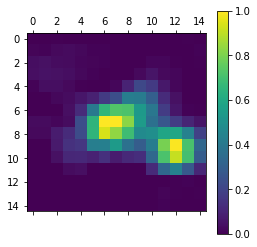

In [10]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((15, 15))
plt.matshow(heatmap)
plt.colorbar()
plt.show()

In this section we will cover the image with the heat map

In [11]:
import cv2

In [12]:
# We use cv2 to load the original image
img_original = cv2.imread(img_path)

# set the intensity map at 0.5
INTENSITY = 0.5

# Resize the heatmap to have the same size as the original image
heatmap_resized = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))

# We convert the heatmap to RGB
heatmap_resized = np.uint8(255 * heatmap_resized)

# We apply the heatmap to the original image
heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Save the image to disk
img_new = heatmap_resized * INTENSITY + img_original

In [13]:
from google.colab.patches import cv2_imshow

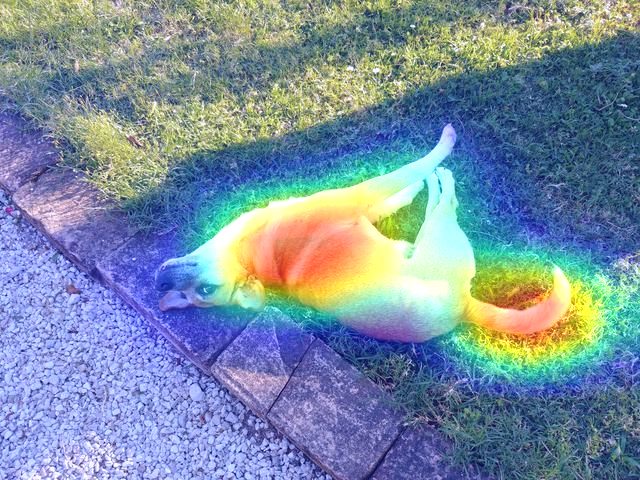

In [14]:
#fig = plt.figure()
#plt.imshow(heatmap)
#plt.colorbar()
#plt.show()
cv2_imshow(img_new)

Visualize heat enlarged heatmap

In [68]:
htmp = heatmap.copy()
htmp = cv2.resize(htmp, (img_original.shape[1], img_original.shape[0]))

In [69]:
# refactoring heatmap
threshold = 0.5
htmp[htmp > threshold] = 1
htmp[htmp < threshold] = 0

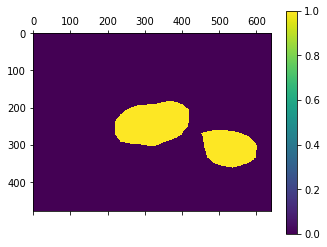

In [70]:
plt.matshow(htmp)
plt.colorbar()
plt.show()

In [71]:
# finding all indices where array element is 1
t = np.argwhere(htmp == 1)

In [72]:
# finding coordinates
ymin, ymax = min(t[:,0]), max(t[:,0])
xmin, xmax = min(t[:,1]), max(t[:,1])

## Drawing Bounding Boxes

we will use functions from the assignment to draw bounding boxes

In [73]:
# importing necessary modules
import os
import random

from PIL import Image, ImageDraw, ImageFont

In [87]:
# functions for bounding boxes
def plot_bbox(img, boxes, classes, scores):
  source_img = Image.open(img)

  xmin, ymin, xmax, ymax = boxes

  draw = ImageDraw.Draw(source_img)
  draw.rectangle(((xmin, ymin), (xmax, ymax)), fill=None, outline='blue', width=2)
  draw.text((xmin+10, ymin+10), str(classes) + str(scores))

  return source_img

In [75]:
classes = decode_predictions(preds, top=1)[0]
class_ = classes[0][1]
score = classes[0][2]

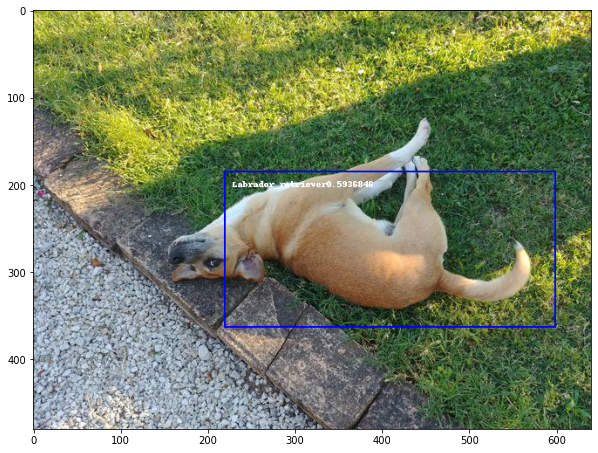

In [88]:
img_bb = plot_bbox(img_path, (xmin,ymin,xmax,ymax), class_, score)

fig = plt.figure(figsize=(10,8))
plt.imshow(img_bb)

## Expanding to the entire dataset

Now we will analyze all the images in the train dataset. In theory this can be expanded to any image. In the section below the application will be expanded to other animals